In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt

In [250]:
df = pd.read_csv('WaitTimesNoLocationClassification.csv', index_col=[0], parse_dates=[0])
df

,DisplayText
Datetime,
2020-08-31 19:50:00,Out the Door (100-200 people)
2019-11-20 11:41:00,Out the Door (100-200 people)
2018-08-24 12:34:00,Out the Door (100-200 people)
2020-08-29 17:09:00,Out the Door (100-200 people)
2020-08-29 18:12:00,Out the Door (100-200 people)
...,...
2016-08-27 13:35:00,Around the Building (200+ people)
2018-08-03 17:10:00,Around the Building (200+ people)
2017-03-27 11:34:00,Around the Building (200+ people)


In [251]:
def f(row):
    if row['DisplayText']== "In the Lobby (0-50 people)":
        val = 0
    elif row['DisplayText']== "Filling the Lobby (50-100 people)":
        val = 1
    elif row['DisplayText']== "Out the Door (100-200 people)":
        val = 2   
    elif row['DisplayText']== "Around the Building (200+ people)":
        val = 3
    return val

df['feature'] = np.nan
df['feature'] = df.apply(f, axis=1)

In [252]:
del df['DisplayText']

In [253]:
split_date = '01-Aug-2020'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [254]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    print(df)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    #df['LocationId'] = df.LocationId

    #X = df[['hour','dayofweek','quarter','month','year',
    #       'dayofyear','dayofmonth','weekofyear', 'LocationId']]
    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear']]
    
    print(X)
    if label:
        y = df[label]
        return X, y
    return X

In [255]:
X_train, y_train = create_features(df_train, label='feature')
X_test, y_test = create_features(df_test, label='feature')

                     feature
Datetime                    
2019-11-20 11:41:00        2
2018-08-24 12:34:00        2
2018-10-02 17:10:00        0
2019-04-02 13:59:00        0
2019-02-05 19:59:00        0
...                      ...
2016-08-27 13:35:00        3
2018-08-03 17:10:00        3
2017-03-27 11:34:00        3
2018-04-01 10:57:00        3
2017-11-02 17:58:00        3

[2462 rows x 1 columns]
                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2019-11-20 11:41:00    11          2        4     11  2019        324   
2018-08-24 12:34:00    12          4        3      8  2018        236   
2018-10-02 17:10:00    17          1        4     10  2018        275   
2019-04-02 13:59:00    13          1        2      4  2019         92   
2019-02-05 19:59:00    19          1        1      2  2019         36   
...                   ...        ...      ...    ...   ...        ...   
2016-08-27 13:

<ipython-input-254-9ce40638487c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-254-9ce40638487c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [256]:
X_test = X_test.reset_index()
del X_test['Datetime']
X_train = X_train.reset_index()
del X_train['Datetime']

In [295]:
train = xgb.DMatrix(X_train, label = y_train)
test = xgb.DMatrix(X_test, label = y_test)
param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 4
}
epochs = 10

In [296]:
model = xgb.train(param, train, epochs)
predictions = model.predict(test)

[06:23:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [297]:
accuracy_score(y_test, predictions)

0.36

In [270]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

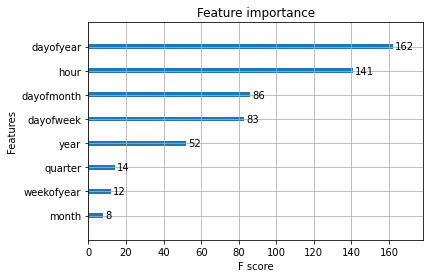

In [271]:
plot_importance(model)
pyplot.show()

In [272]:
import seaborn as sn
import matplotlib.pyplot as plt
df = pd.DataFrame(list(zip(predictions, y_test)),
               columns =['prediction', 'actual'])
df

,prediction,actual
0,3.0,2
1,3.0,2
2,3.0,2
3,3.0,2
4,3.0,2
...,...,...
545,2.0,3
546,2.0,3
547,2.0,3
548,2.0,3


In [273]:
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0.0,1.0,2.0,3.0
Actual,,,,
0,6,0,24,21
1,4,0,40,19
2,4,6,148,75
3,5,5,149,44


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

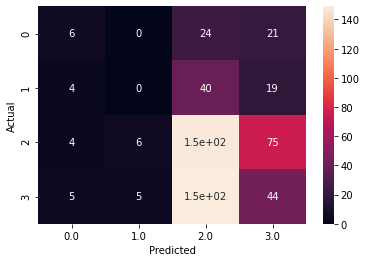

In [274]:
data = {'y_Actual':    [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        'y_Predicted': [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
sn.heatmap(confusion_matrix, annot=True)